In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
nb_dir = os.path.dirname(os.path.split(os.getcwd())[0])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from turicreate import SFrame, load_sframe
from pathlib import Path
import turicreate.aggregate as agg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import re
import datetime
from matplotlib.backends.backend_pdf import PdfPages
import geopandas


In [4]:
from collections import defaultdict
from itertools import chain

In [5]:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i + n]

def get_d(sf_corr):
    for data in sf_corr.groupby("Disease"):
        if len(data[1]) >5:
            yield data[1].sort_values("Year")

In [6]:

plt.figure(figsize=(20, 10))

sns.set(style="ticks")
def create_gird(df, col, hue,x,y):

    # Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(df, col=col, hue=hue, palette="tab20c",
                         col_wrap=3, height=4.5)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

    # Draw a horizontal line to show the starting point
    grid.map(plt.axhline, y=0, ls=":", c=".5")

    # Draw a line plot to show the trajectory of each random walk
    grid.map(plt.plot, x, y)


    # Adjust the arrangement of the plots
    grid.fig.tight_layout(w_pad=1)
    return grid

<Figure size 1440x720 with 0 Axes>

In [7]:
diseases_id= load_sframe("Data/diseases_id.csv")
disease_names= SFrame.read_csv("Data/disease_names.csv")

Finished parsing file /storage/homedir/dima/Projects/Giga/ScienceDynamics/examples/Coronavirus/Data/diseases_id.csv

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct


Parsing completed. Parsed 18 lines in 0.03184 secs.

the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /storage/homedir/dima/Projects/Giga/ScienceDynamics/examples/Coronavirus/Data/diseases_id.csv

Parsing completed. Parsed 18 lines in 0.026614 secs.

Finished parsing file /storage/homedir/dima/Projects/Giga/ScienceDynamics/examples/Coronavirus/Data/disease_names.csv

Parsing completed. Parsed 9 lines in 0.025764 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /storage/homedir/dima/Projects/Giga/ScienceDynamics/examples/Coronavirus/Data/disease_names.csv

Parsing completed. Parsed 9 lines in 0.025355 secs.

In [8]:
spothlight = ["SARS","MERS Coronavirus", "Avian Influenza","Ebola", "Influenza", "HIV/AIDS","Hepatitis B","Hepatitis C", "Swine Flu"]

In [9]:
import networkx as nx

## Pre-Processing

In [10]:
from ScienceDynamics.datasets.microsoft_academic_graph import MicrosoftAcademicGraph
from ScienceDynamics.config.configs import DATASETS_BASE_DIR
mag = MicrosoftAcademicGraph(DATASETS_BASE_DIR)

In [44]:
diseases_mag = load_sframe("Data/mag/diseases_med_mag.sframe")

In [45]:
diseases_mag = diseases_mag.filter_by(spothlight,"disease")

In [46]:
diseases_mag = diseases_mag.rename({"disease":"Disease"})

In [47]:
diseases_mag= diseases_mag[diseases_mag["Ref Number"]>5]

In [15]:
paper_ids = diseases_mag["PaperId"]

In [16]:
paper_author_aff = mag.paper_author_affiliations

In [17]:
paper_author_aff = paper_author_aff.filter_by(paper_ids,"PaperId")

Fill affilations that are missing in the affilation table

In [18]:
import geonamescache
gc = geonamescache.GeonamesCache()
cities = gc.get_cities()
countries = gc.get_countries()
cities = {v['name'] for k, v in cities.items()}
countries = {v['name'] for k, v in countries.items()}

In [19]:
import re
from geonamescache.mappers import country
mapper = country(from_key='iso', to_key='name')

def add_location_from_original_affilation(paper_author_aff):
    paper_author_aff["AffiliationId"] = paper_author_aff["AffiliationId"].astype(int)
    paper_author_aff["NormalizedAffiliation"] = paper_author_aff["OriginalAffiliation"].apply(lambda x: set(re.sub(r"[^a-zA-Z0-9]+", ' ', x).split(" ")))
    
    paper_author_aff["City_A"] = paper_author_aff["NormalizedAffiliation"].apply(lambda x: set(x)&cities)
    paper_author_aff["City_A"] = paper_author_aff["City_A"].apply(lambda x: x[0] if x else "")
    paper_author_aff["City_A"] = paper_author_aff["City_A"].apply(lambda x: None if x=="" else x)

    paper_author_aff["Country_A"] = paper_author_aff["NormalizedAffiliation"].apply(lambda x: set(x)&countries)
    paper_author_aff["Country_A"] = paper_author_aff["Country_A"].apply(lambda x:x[0] if x else "")
    
    paper_author_aff["Country_Temp"] = paper_author_aff.apply(lambda x: gc.get_cities_by_name(x["City_A"]) if x["City_A"] and not x["Country_A"] else [] )
    paper_author_aff["Country_Temp"] = paper_author_aff["Country_Temp"].apply(lambda x: [l.popitem()[1] for l in x] )
    paper_author_aff["Country_A"] = paper_author_aff.apply(lambda x: x["Country_A"] if x["Country_A"] is not None  else mapper(x["Country_Temp"][0]["countrycode"]) if len(x["Country_Temp"])==1 else "" )
    paper_author_aff["Country_A"] = paper_author_aff["Country_A"].apply(lambda x: None if x=="" else x)
    return paper_author_aff.remove_column("Country_Temp")

In [20]:
paper_author_aff = add_location_from_original_affilation(paper_author_aff)

Using default 12 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 24)"

Note that increasing the degree of parallelism also increases the memory footprint.

In [21]:
def merge_with_affilations(paper_author_aff, affiliations):
    paper_author_aff = paper_author_aff.join(affiliations, on={"AffiliationId":"AffiliationId"}, how="left")
    
    paper_author_aff["Country"] = paper_author_aff.apply(lambda x: x["Country_A"] if x["Country"]is None else x["Country"])
    paper_author_aff["City"] = paper_author_aff.apply(lambda x: x["City_A"] if x["City"] is None else x["City"])
    return paper_author_aff


In [22]:
paper_author_aff = merge_with_affilations(paper_author_aff, mag.affiliations)
paper_author_aff = paper_author_aff[(paper_author_aff["Country"]!=None)]

## Author Country

In [23]:

paper_author_aff = paper_author_aff[paper_author_aff["Country"]!=None]
paper_author_aff_country = paper_author_aff[["PaperId","AuthorId", "Country"]].unstack(["AuthorId", "Country"])
paper_author_aff_country["num_countries"] = paper_author_aff_country["Dict of AuthorId_Country"].apply(lambda x: len({v for k,v in x.items() if v!=""  }))


In [48]:
try:
    diseases_mag= diseases_mag.remove_columns(["Dict of AuthorId_Country","num_countries"])
except:
    pass
diseases_mag = diseases_mag.join(paper_author_aff_country, on={"PaperId":"PaperId"})

In [49]:
diseases_mag = diseases_mag[diseases_mag["num_countries"] > 0]

In [50]:
diseases_mag["Year"] = diseases_mag["Year"].astype(int)

In [28]:
diseases_mag.groupby("Disease",operations={"num_countries":agg.AVG("num_countries"), "count":agg.COUNT() }).sort("num_countries",False).save("output/Collab/author_counter.csv")

In [29]:
df = diseases_mag.groupby("Year",operations={"Average Distinct Countries":agg.AVG("num_countries"), "count":agg.COUNT() }).sort("Year",False)

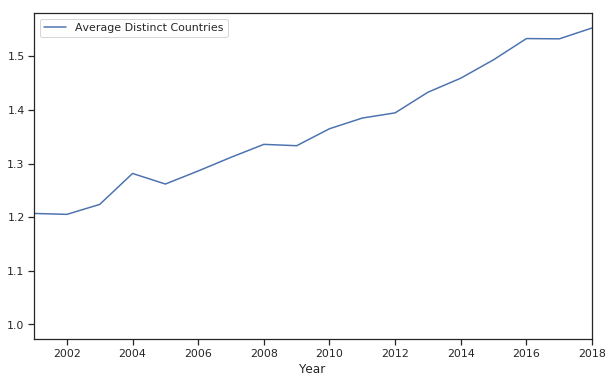

In [30]:
df.to_dataframe().plot(x="Year", y="Average Distinct Countries", xlim=(2001,2018), figsize=(10,6))

In [31]:
df2 = diseases_mag.groupby(["Disease", "Year"],operations={"Average Number of Countries":agg.AVG("num_countries"), "count":agg.COUNT() }).sort("Year",False)

In [32]:
df2 = df2.sort(["Disease", "Year"])

In [33]:
df2 = df2[(df2["count"] >5)&(df2["Year"] >2001)]

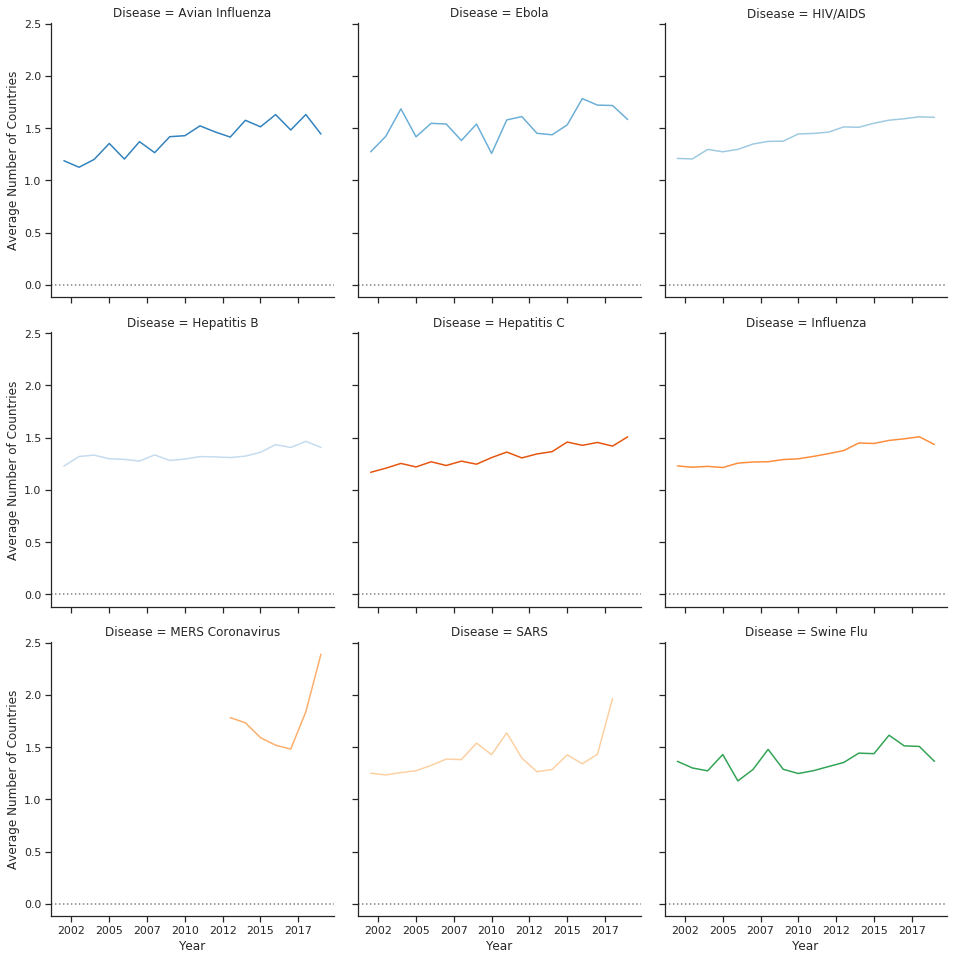

In [34]:


plt.rc('text', usetex=False)

create_gird(df2.to_dataframe(),"Disease","Disease","Year", "Average Number of Countries")
# plt.savefig('output/Collab/countries.png')
# plt.close()



In [35]:
diseases_mag["num_countries"].value_counts()

value,count
1,145931
2,35190
3,8010
4,2212
5,794
6,461
7,287
8,192
9,127
10,68


In [36]:
countries_p  = diseases_mag.groupby(["Disease", "Year"], {"Count": agg.COUNT(),"Freq":agg.FREQ_COUNT("num_countries")})

In [37]:
countries_p["Colab"] = countries_p["Freq"].apply(lambda x: sum([v for k,v in x.items() if k>1]))

In [38]:
countries_p["Colab%"] = countries_p["Colab"] / countries_p["Count"]

In [39]:
countries_p=countries_p.sort(["Disease","Year"])

In [40]:
countries_p = countries_p[(countries_p["Year"]>2001)&(countries_p["Year"]<2019)]

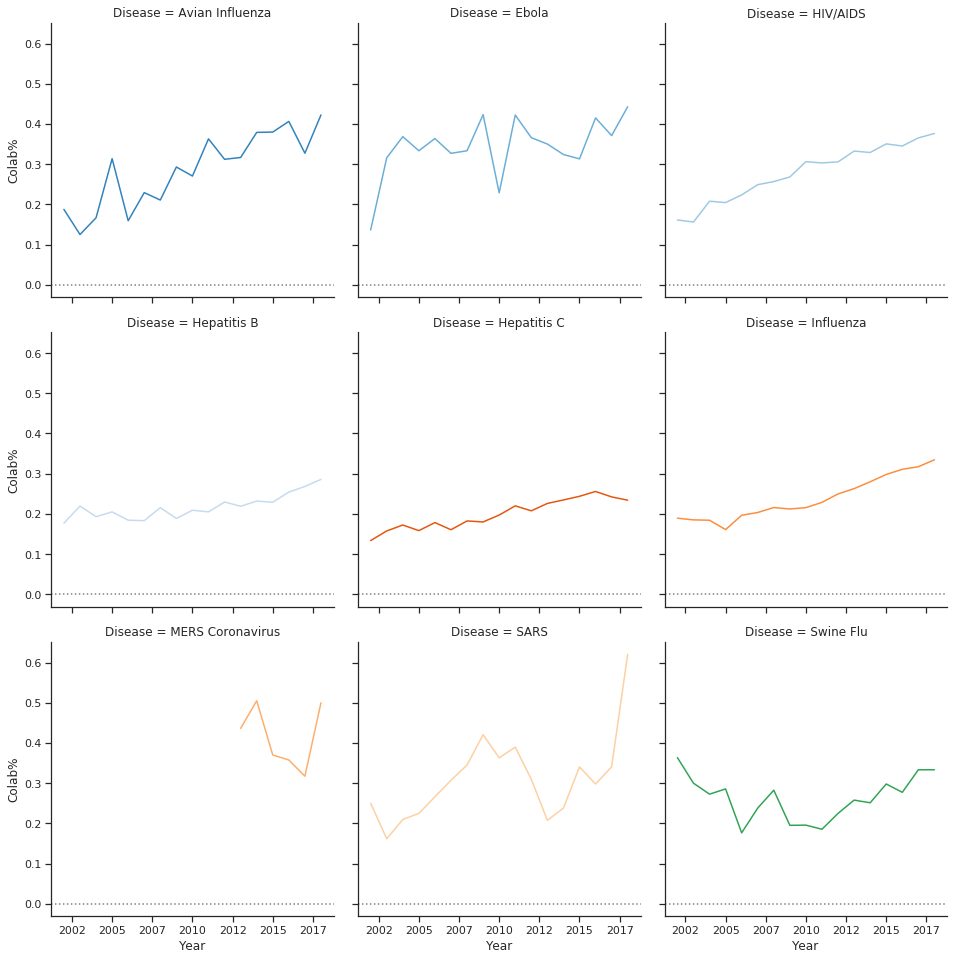

In [41]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt


plt.rc('text', usetex=False)
create_gird(countries_p.to_dataframe(),"Disease","Disease","Year", "Colab%")
# plt.savefig('output/Collab/colab_p2.png')
# plt.close()



### Pair Colab

In [42]:
from itertools import combinations
def get_research_cop(diseases_mag, field="Dict of AuthorId_Country", n=2):
    diseases_mag["temp"] = diseases_mag[field].apply(lambda x: [v for v in set(x.values()) if v!=""])
    diseases_mag2 = diseases_mag[diseases_mag["temp"].apply(lambda x: len(x) >= n)]
    diseases_mag2= diseases_mag2[diseases_mag2["temp"]!=None]
    diseases_mag2["temp"] = diseases_mag2["temp"].apply(lambda x: sorted(x))
    diseases_mag2["con_pairs"] = diseases_mag2["temp"].apply(lambda x: list(combinations(x, n)))
    return  diseases_mag2.stack("con_pairs", new_column_name="con_pairs")


In [51]:
diseases_mag_pairs = get_research_cop(diseases_mag,n=2)

In [52]:
diseases_mag_pairs = diseases_mag_pairs.groupby(["Disease","Year","con_pairs"],agg.COUNT)

In [53]:
diseases_mag_pairs.sort("Count",False).save("output/Collab/pairs.csv")

In [58]:
diseases_mag["first_atuhor_country"] = diseases_mag.apply(lambda x: x["Dict of AuthorId_Country"][int(x["Authors List Sorted"][0])] if int(x["Authors List Sorted"][0]) in x["Dict of AuthorId_Country"] else "")

In [59]:
diseases_mag["last_atuhor_country"] = diseases_mag.apply(lambda x: x["Dict of AuthorId_Country"][int(x["Authors List Sorted"][-1])] if int(x["Authors List Sorted"][-1]) in x["Dict of AuthorId_Country"] else "")

In [60]:
first_atuhor_country = diseases_mag.groupby(["Disease","Year","first_atuhor_country"], {"Count":agg.COUNT()})
last_atuhor_country = diseases_mag.groupby(["Disease","Year","last_atuhor_country"], {"Count":agg.COUNT()})

In [61]:
import pycountry
import  functools
# @functools.lru_cache(maxsize=8048)
def get_iso(txt):
    try:
        return pycountry.countries.search_fuzzy(txt)[0].alpha_3
    except:
        pass
    return ""


In [62]:
diseases_mag_pairs = diseases_mag_pairs.groupby(["con_pairs", "Disease"],{ "Count":agg.SUM("Count")})

In [64]:
# These examples are inspired from http://geopandas.org/mapping.html


world = geopandas.read_file("http://thematicmapping.org/downloads/TM_WORLD_BORDERS_SIMPL-0.3.zip")


In [69]:
df = diseases_mag_pairs.to_dataframe()

In [70]:
sf = df.groupby("Disease").apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)  

In [71]:
sf =SFrame(sf)

In [72]:
world["ISO3"] = world.apply(lambda x: get_iso(x["name"]) if x["ISO3"] == "-99" else x["ISO3"], axis=1)

In [73]:
world["cord"] = world["geometry"].centroid


In [74]:
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='name')

In [75]:
import networkx as nx

In [76]:
g = nx.Graph()

In [78]:
pairs = diseases_mag_pairs.groupby(["con_pairs", "Disease"],{ "Count":agg.SUM("Count")})

In [79]:
inter = get_research_cop(diseases_mag ,"Dict of AuthorId_Country", n=1).groupby(["Disease","con_pairs"],agg.COUNT).sort("Count",False)

In [80]:
inter["Country"] = inter["con_pairs"].apply(lambda x: x[0])

In [81]:
diseases_mag_pairs

Disease,con_pairs,Count
Influenza,"[France, New Zealand]",5
Influenza,"[Hungary, Poland]",12
HIV/AIDS,"[Democratic Republic ofthe Congo, Morocco] ...",1
Hepatitis B,"[Norway, Turkey]",1
Swine Flu,"[Norway, Turkey]",1
Hepatitis B,"[Algeria, Portugal]",1
Influenza,"[Australia, Ireland]",6
Avian Influenza,"[Iceland, United States]",2
Hepatitis B,"[Israel, Italy]",11
Ebola,"[Japan, United Kingdom]",5


In [82]:
import json
graphs = dict(zip(spothlight,[nx.Graph() for x in spothlight]))
for d in tqdm(spothlight):
    total_papers = inter[inter["Disease"]==d]["Count"].sum()
    for line in inter[inter["Disease"]==d]:
        if line['Count']/total_papers>0.05:
            
            graphs[d].add_node(line["Country"], weight=line['Count'])
    nodes = set(graphs[d].nodes)
    for line in pairs[pairs["Disease"]==d]:
        if line["con_pairs"][0] in nodes and line["con_pairs"][1] in  nodes:
            graphs[d].add_edge(*line["con_pairs"], weight=line['Count'])
    nx.write_gml(  graphs[d], f"output/Collab/Cyto/{d.replace('/','-')}.gml")
    with open(f"output/Collab/Cyto/{d.replace('/','-')}.json", "w") as f :
        f.write(json.dumps(nx.cytoscape_data(graphs[d])))


/storage/homedir/dima/miniconda3/envs/promed/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
import matplotlib.pyplot as plt

In [85]:
sars = world.merge(inter[inter["Disease"]=="SARS"].to_dataframe(),left_on="NAME", right_on="Country")

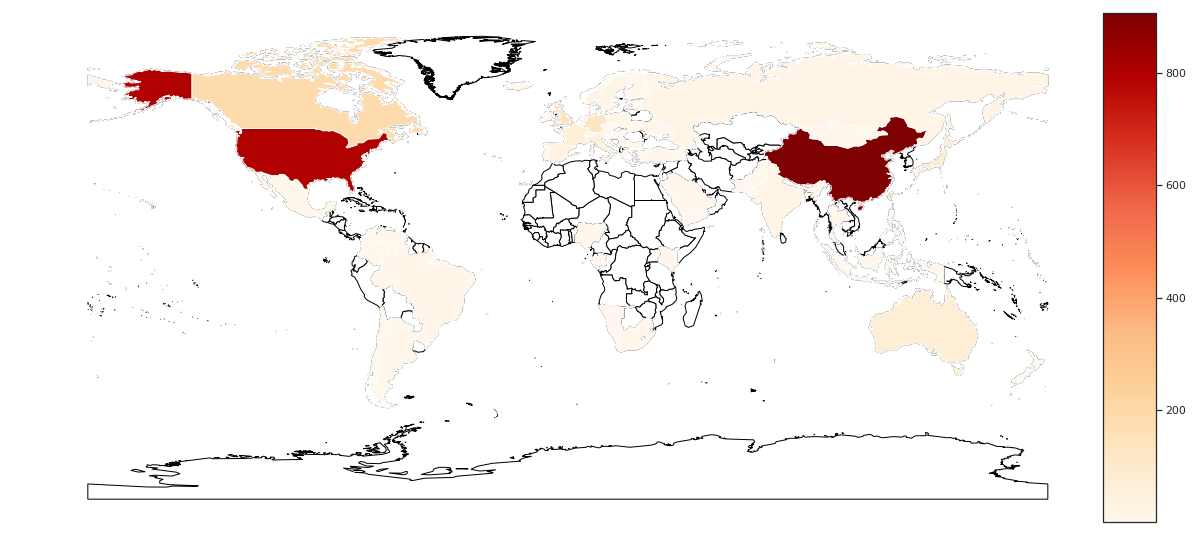

In [86]:
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,1,figsize=(20,20))

# ax.set_aspect('equal')
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

# world['pop_est_log'] = world['pop_est'].apply(lambda i: math.log(i) if i >0 else 0)
s = sars.plot(ax=ax, column="Count",cmap="OrRd",  legend=True, cax=cax, zorder=2)
world.plot(color='white', edgecolor='black',ax=s)
ax.set_axis_off()


In [87]:
inter = inter.join(inter.groupby("Disease",{ "Total":agg.SUM("Count")}))

In [88]:
inter["p%"] = inter["Count"]/ inter["Total"]

In [89]:
inter = inter.sort(["Disease","p%"],False)

In [90]:
spothlight = sorted(spothlight,reverse=True)

In [91]:
res = []
for d in spothlight:
    res+=list(inter[inter["Disease"]==d]["p%"].cumulative_sum())

In [92]:
inter["cumulative_sum"]=res

In [93]:
inter["Pie_Country"] = inter.apply(lambda x: "Others" if x["p%"]<0.02 else x["Country"])

In [94]:
inter2 = inter.groupby(["Disease","Pie_Country"],{"Count":agg.SUM("Count")})

In [95]:
countries = list(inter2["Pie_Country"].unique())

In [96]:
inter2 = inter2.sort(["Disease","Count"],False)

In [97]:
from matplotlib.colors import ListedColormap
import math

def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(math.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = plt.cm.GnBu_r(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.1,-0.9/b)
#     print(ret)
    return ret

In [98]:

colordict={}

for l,c in zip(countries,generate_colormap(len(countries))):
    colordict[l]=c

# fig = plt.figure(figsize=[10, 10])
# ax = fig.add_subplot(111)

# pie_wedge_collection = ax.pie(slices, labels=labels, labeldistance=1.05)#, autopct=make_autopct(slices))

# for pie_wedge in pie_wedge_collection[0]:
#     pie_wedge.set_edgecolor('white')
#     pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

/storage/homedir/dima/miniconda3/envs/promed/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


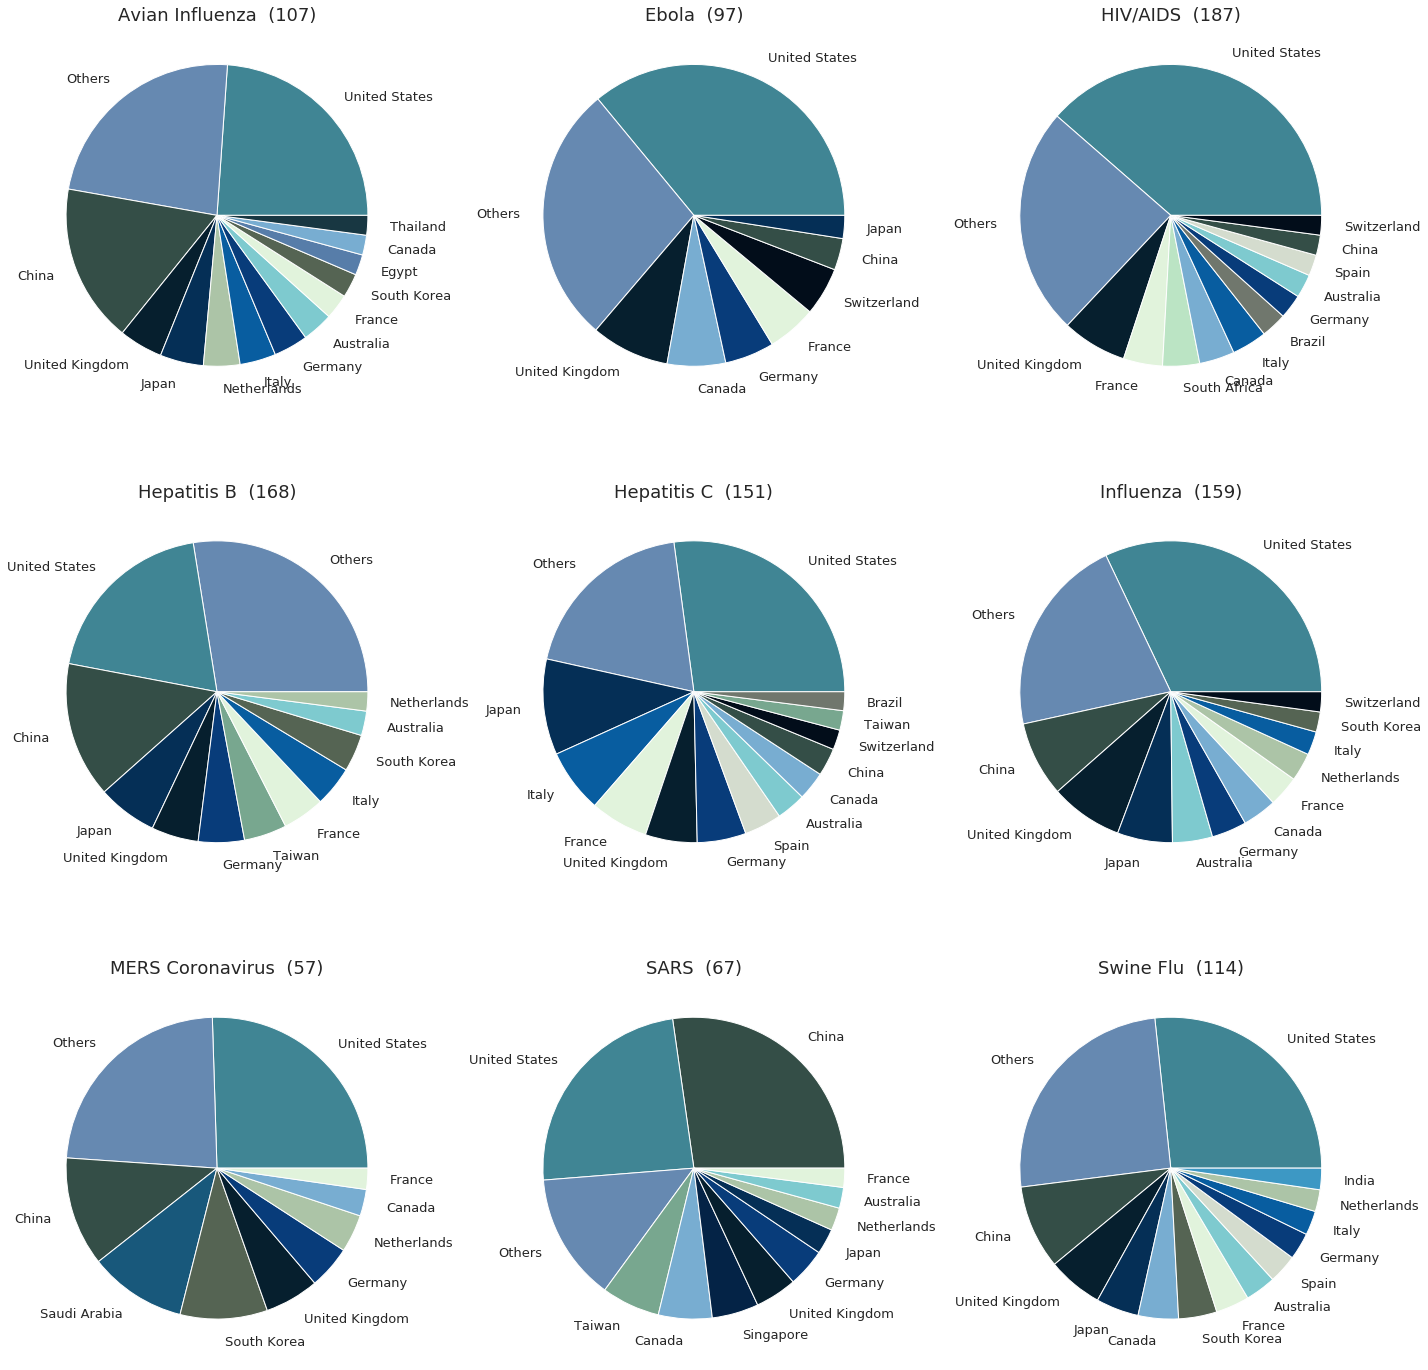

In [99]:
fig, axes = plt.subplots(3,3,figsize=(20,20))
axes = axes.flatten()

for d,ax in tqdm(zip(sorted(spothlight),axes)):

    ax.set_title(f'{d}  ({len(set(inter[inter["Disease"]==d]["Country"]))})', fontsize=18)
    data = inter2[inter2["Disease"]==d]
    pie_wedge_collection = ax.pie(data["Count"],  labels=data["Pie_Country"], textprops={'fontsize': 13},  labeldistance=1.15)
    
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
fig.tight_layout()


In [100]:
world2 = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [101]:
world2= world2.replace("United States of America", "United States")

In [102]:
inter = inter.join(SFrame(world2[["name","continent"]]), on={"Country":"name"},how='left')

In [103]:
first_author =  diseases_mag.groupby(["Disease","first_atuhor_country"], agg.COUNT())

In [104]:
first_author = first_author[first_author["first_atuhor_country"]!=""]

In [105]:
first_author = first_author.join(first_author.groupby("Disease",{ "Total":agg.SUM("Count")}))

In [106]:
first_author["p%"] = first_author["Count"]/ first_author["Total"]

In [107]:
first_author = first_author.sort(["Disease","p%"],False)

In [108]:
spothlight = sorted(spothlight,reverse=True)

In [109]:
res = []
for d in spothlight:
    res+=list(first_author[first_author["Disease"]==d]["p%"].cumulative_sum())

In [110]:
first_author["cumulative_sum"]=res

In [111]:
for d in spothlight:
    print(first_author[first_author["Disease"]==d][:6][["Disease","first_atuhor_country","cumulative_sum"]])

+-----------+----------------------+---------------------+
|  Disease  | first_atuhor_country |    cumulative_sum   |
+-----------+----------------------+---------------------+
| Swine Flu |    United States     | 0.26844679983693437 |
| Swine Flu |        China         |  0.3754586220953934 |
| Swine Flu |    United Kingdom    | 0.42662046473705667 |
| Swine Flu |        Canada        |  0.4763554830819405 |
| Swine Flu |        Japan         |  0.5254790052996331 |
| Swine Flu |     South Korea      |  0.5743986954749286 |
+-----------+----------------------+---------------------+
[6 rows x 3 columns]

+---------+----------------------+---------------------+
| Disease | first_atuhor_country |    cumulative_sum   |
+---------+----------------------+---------------------+
|   SARS  |        China         | 0.31418624891209745 |
|   SARS  |    United States     |  0.5422106179286336 |
|   SARS  |        Taiwan        |  0.6144473455178415 |
|   SARS  |        Canada        |  0.67449956

In [112]:
first_author = first_author.join(SFrame(world2[["name","continent"]]), on={"first_atuhor_country":"name"},how='left')

In [113]:
first_author_continent = first_author.groupby(["Disease","continent"],{"Count":agg.SUM("Count"), "p%":agg.SUM("p%")})

In [114]:
first_author_continent[first_author_continent["continent"]!=None].sort(["Disease","p%"]).print_rows(63)

+------------------+---------------+-------+-----------------------+
|     Disease      |   continent   | Count |           p%          |
+------------------+---------------+-------+-----------------------+
| Avian Influenza  | South America |   26  | 0.0075449796865931515 |
| Avian Influenza  |     Africa    |  117  |  0.03395240858966918  |
| Avian Influenza  |    Oceania    |  118  |  0.03424260011607661  |
| Avian Influenza  |     Europe    |  786  |   0.2280905397562391  |
| Avian Influenza  | North America |  936  |   0.2716192687173534  |
| Avian Influenza  |      Asia     |  1439 |   0.4175856065002902  |
|      Ebola       | South America |   14  |  0.006071118820468344 |
|      Ebola       |    Oceania    |   39  |  0.016912402428447527 |
|      Ebola       |     Africa    |  123  |   0.0533391153512576  |
|      Ebola       |      Asia     |  240  |  0.10407632263660016  |
|      Ebola       |     Europe    |  674  |  0.29228100607111884  |
|      Ebola       | North America